商品ごとの補正を導入

pymc.Mixtureを用いて潜在変数を積分消去

参考：https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Mixture.html

In [166]:
from scipy.stats import dirichlet
from scipy.special import kl_div
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets

import os


In [167]:
# データセット可視化メソッド
def plot_data(X_train, y_train, name):
    plt.figure(figsize=(12,5))

    # true
    # plt.subplot(1, 2, 1)
    label = np.unique(y_train)
    # カラーマップを定義
    cmap = plt.get_cmap('tab10')  # タブルランカラーマップを使用
    colors = [cmap(i) for i in range(len(label))]

    for class_label in label:
        class_data = X_train[y_train == class_label][:,:,0].T
        plt.plot(class_data, label=f'_Class {class_label}', color=colors[class_label - 1], alpha=0.4)
        plt.plot([], label=f'Class {class_label}', color=colors[class_label - 1], alpha=0.3)

    plt.legend()
    # plt.text(0.05,0.95,'pred', transform=plt.gca().transAxes)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{name}')

    plt.tight_layout()
    plt.show()

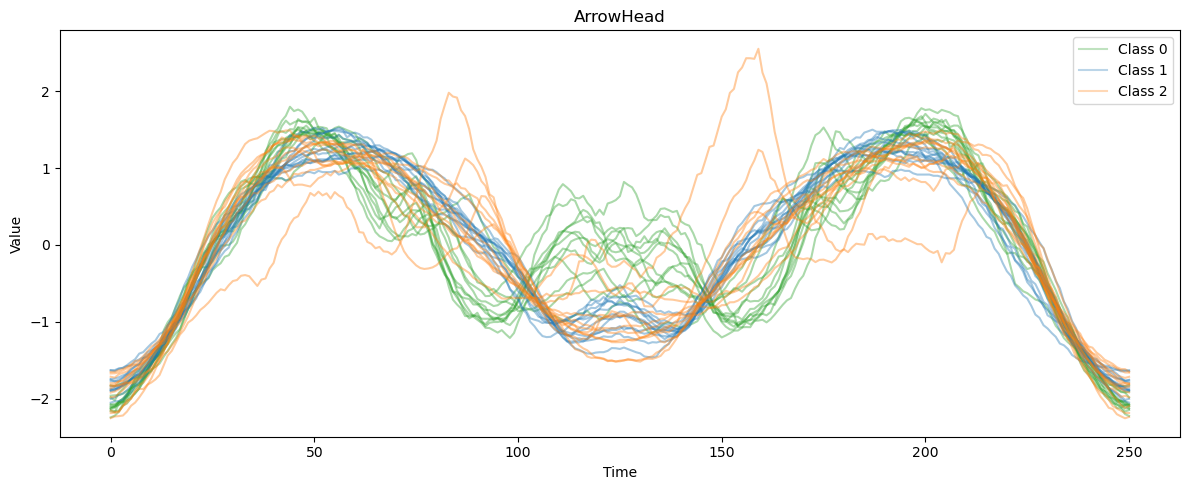

In [168]:
data_name = 'ArrowHead'

# データセットの読み込み（ここではUCR/UEAデータセットを使用）
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(data_name)

plot_data(X_train, y_train, data_name)

In [169]:
y_train

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])

trainデータの形状確認

In [170]:
X_train[:,:,0].shape

(36, 251)

trainデータのlabel_1の形状を変える

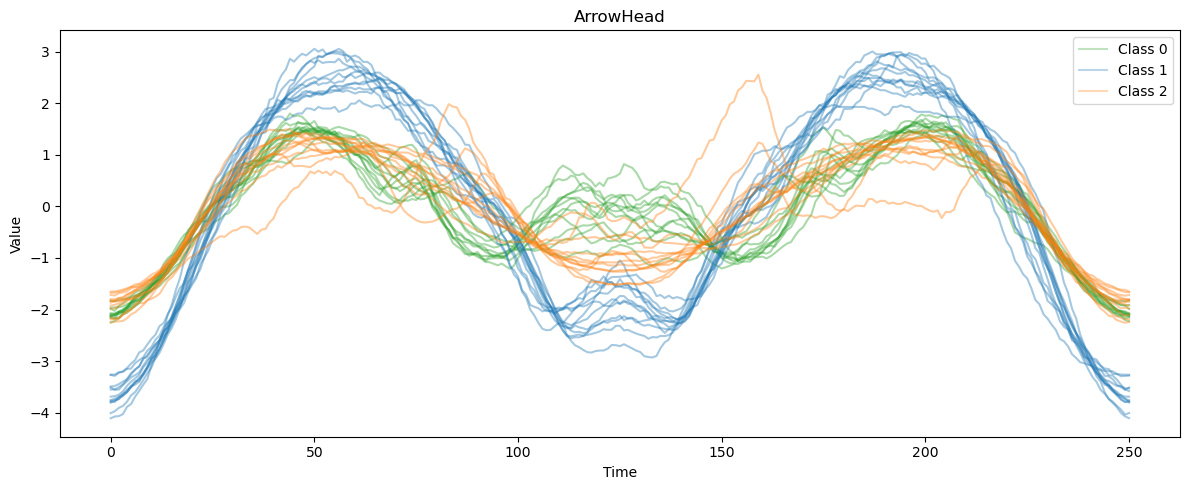

In [171]:
X_train[y_train==1] = X_train[y_train==1] * 2

plot_data(X_train, y_train, data_name)

trainデータ全体の頻度分布をからbinsの設定を取得

In [172]:
hist, bin_edges = np.histogram(X_train[:,:,0].T, bins='sturges', density=False)
print('hist:', hist,'\nbin_edges:', bin_edges)

bin_max = bin_edges.max()
bin_min = bin_edges.min()
bin_num = len(hist)

print('bin_max:', bin_max, '\nbin_min:', bin_min, '\nbin_num:', bin_num)

hist: [  63  133  123  232  615  599  926 1032 1010 1039 1209 1069  360  453
  173] 
bin_edges: [-4.1074854  -3.62999617 -3.15250695 -2.67501772 -2.19752849 -1.72003927
 -1.24255004 -0.76506081 -0.28757159  0.18991764  0.66740687  1.14489609
  1.62238532  2.09987455  2.57736377  3.054853  ]
bin_max: 3.054853 
bin_min: -4.1074854 
bin_num: 15


上記のbins設定でtraiｎデータ全体を頻度分布に変換

In [173]:
hist_li = []
for d in range(X_train.shape[0]):
    hist_ = np.histogram(X_train[d], bins=bin_num, range=(bin_min, bin_max), density=False)[0] + 0.000001
    hist_li.append(hist_ / hist_.sum()) # 合計を１にスケール

X_hist = np.array(hist_li)
X_hist

array([[3.98406351e-09, 3.98406351e-09, 3.98406351e-09, 3.98406351e-09,
        6.37450201e-02, 5.57768931e-02, 6.77290836e-02, 2.90836640e-01,
        6.77290836e-02, 1.43426290e-01, 1.23505973e-01, 1.87250989e-01,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       [3.98406351e-09, 5.97609566e-02, 3.58565755e-02, 1.23505973e-01,
        7.96812741e-02, 4.38247026e-02, 4.78087661e-02, 3.98406391e-02,
        5.17928296e-02, 6.77290836e-02, 7.17131471e-02, 7.17131471e-02,
        7.96812741e-02, 1.79282862e-01, 4.78087661e-02],
       [3.98406351e-09, 3.98406351e-09, 3.98406351e-09, 3.98406351e-09,
        4.78087661e-02, 5.97609566e-02, 1.95219116e-01, 1.19521909e-01,
        1.11553782e-01, 1.19521909e-01, 1.59362544e-01, 1.87250989e-01,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       [3.98406351e-09, 3.98406351e-09, 3.98406351e-09, 3.98406351e-09,
        6.77290836e-02, 4.38247026e-02, 1.23505973e-01, 1.51394417e-01,
        2.03187243e-01, 1.43426290e-0

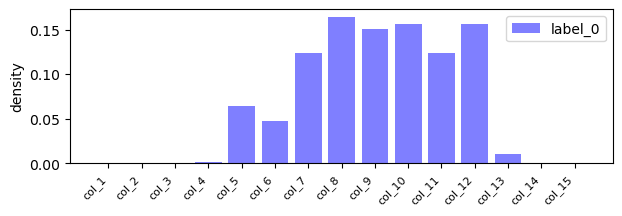

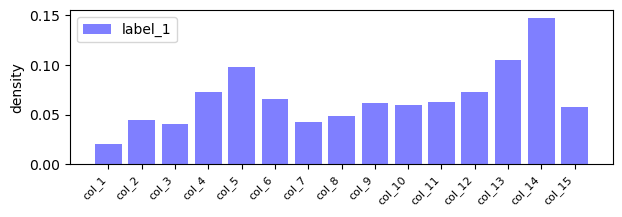

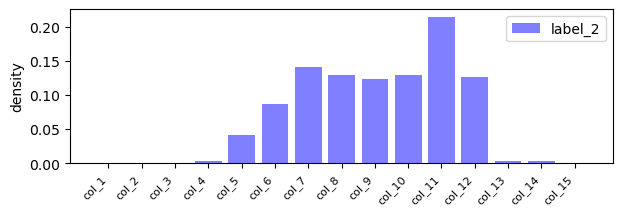

In [174]:
X_cols = [f'col_{i+1}' for i in range(X_hist.shape[1])]

for i in range(3):
    # ヒストグラムをプロット
    plt.figure(figsize=(7,2))
    plt.bar(X_cols, X_hist[y_train==i].mean(axis=0), color='blue', alpha=0.5, label=f'label_{i}')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
    # plt.bar(X_cols, X_hist[y_train==1].mean(axis=0), color='red', alpha=0.5, label='label_1')
    # plt.bar(X_cols, X_hist[y_train==2].mean(axis=0), color='green', alpha=0.5, label='label_2')
    # plt.xlabel('')  # x軸ラベル
    plt.ylabel('density')  # y軸ラベル
    plt.title('')  # グラフタイトル
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.legend()
    plt.show()  # グラフを表示

### 商品ラベルの作成、補正の適用

In [175]:
y_train = np.concatenate([y_train,y_train])
y_train

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1,
       2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2,
       0, 1, 2, 0, 1, 2])

In [176]:
X_hist = np.concatenate([X_hist,X_hist])
X_hist.shape

(72, 15)

In [177]:
np.random.seed(1)
product = np.random.randint(2, size=72)
product

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1])

In [178]:
np.random.seed(1)
p1_cor = np.random.normal(0, 0.05, size=15)
p1_cor

array([ 0.08121727, -0.03058782, -0.02640859, -0.05364843,  0.04327038,
       -0.11507693,  0.08724059, -0.03806035,  0.01595195, -0.01246852,
        0.0731054 , -0.10300704, -0.01612086, -0.01920272,  0.05668847])

In [179]:
X_hist[product==1] = X_hist[product==1] + p1_cor
X_hist = np.where(X_hist<0, 0.000001, X_hist)
X_hist = X_hist / np.tile(X_hist.sum(axis=1)[:,np.newaxis], 15) #総和を１にスケール
X_hist

array([[7.07364473e-02, 8.70953252e-07, 8.70953252e-07, ...,
        8.70953252e-07, 8.70953252e-07, 4.93730126e-02],
       [7.76870981e-02, 2.79051021e-02, 9.03732354e-03, ...,
        6.07977094e-02, 1.53122132e-01, 9.99551817e-02],
       [3.98406351e-09, 3.98406351e-09, 3.98406351e-09, ...,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       ...,
       [3.98406351e-09, 3.98406351e-09, 3.98406351e-09, ...,
        2.39043850e-02, 3.98406351e-09, 3.98406351e-09],
       [1.07028393e-01, 1.68930664e-02, 1.45168504e-03, ...,
        5.06256262e-02, 1.25766621e-01, 1.45497954e-01],
       [7.30167154e-02, 8.99029399e-07, 8.99029399e-07, ...,
        8.99029399e-07, 8.99029399e-07, 5.09646066e-02]])

In [180]:
X_hist.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

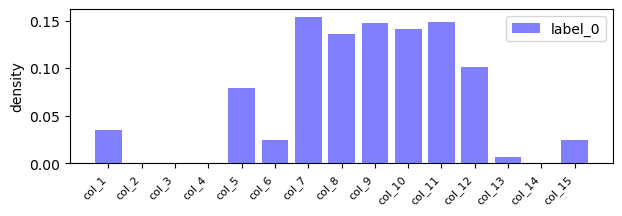

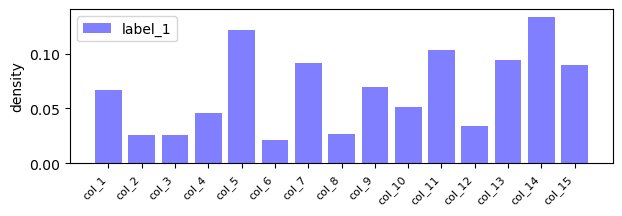

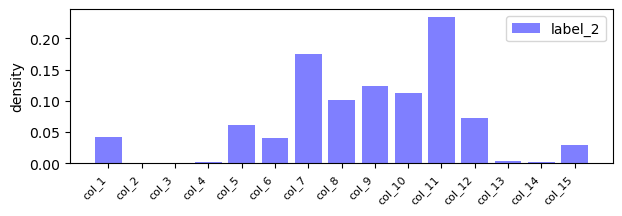

In [181]:
X_cols = [f'col_{i+1}' for i in range(X_hist.shape[1])]

for i in range(3):
    # ヒストグラムをプロット
    plt.figure(figsize=(7,2))
    plt.bar(X_cols, X_hist[y_train==i].mean(axis=0), color='blue', alpha=0.5, label=f'label_{i}')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
    # plt.bar(X_cols, X_hist[y_train==1].mean(axis=0), color='red', alpha=0.5, label='label_1')
    # plt.bar(X_cols, X_hist[y_train==2].mean(axis=0), color='green', alpha=0.5, label='label_2')
    # plt.xlabel('')  # x軸ラベル
    plt.ylabel('density')  # y軸ラベル
    plt.title('')  # グラフタイトル
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.legend()
    plt.show()  # グラフを表示

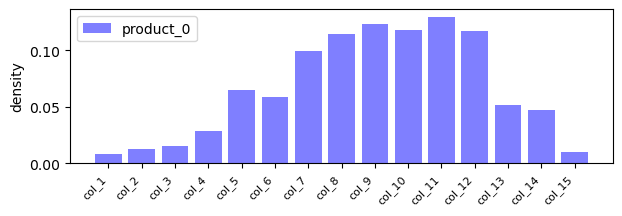

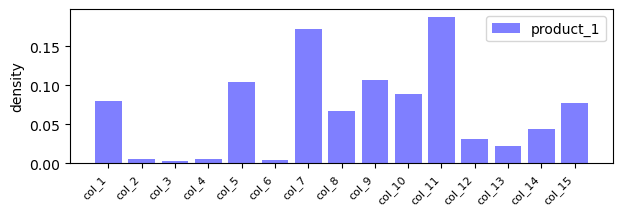

In [182]:
X_cols = [f'col_{i+1}' for i in range(X_hist.shape[1])]

for i in range(2):
    # ヒストグラムをプロット
    plt.figure(figsize=(7,2))
    plt.bar(X_cols, X_hist[product==i].mean(axis=0), color='blue', alpha=0.5, label=f'product_{i}')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
    # plt.bar(X_cols, X_hist[y_train==1].mean(axis=0), color='red', alpha=0.5, label='label_1')
    # plt.bar(X_cols, X_hist[y_train==2].mean(axis=0), color='green', alpha=0.5, label='label_2')
    # plt.xlabel('')  # x軸ラベル
    plt.ylabel('density')  # y軸ラベル
    plt.title('')  # グラフタイトル
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.legend()
    plt.show()  # グラフを表示

In [183]:
# CPU Multi
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax
print(jax.default_backend())
print(jax.devices("cpu"))

cpu
[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


In [184]:
import pymc as pm
import arviz as az
print('version.', pm.__version__)
from pytensor import tensor as pt

version. 5.8.0


### 複数クラスに対するパラメータ推定

モデル定義

In [185]:
data_ = X_hist
data_

array([[7.07364473e-02, 8.70953252e-07, 8.70953252e-07, ...,
        8.70953252e-07, 8.70953252e-07, 4.93730126e-02],
       [7.76870981e-02, 2.79051021e-02, 9.03732354e-03, ...,
        6.07977094e-02, 1.53122132e-01, 9.99551817e-02],
       [3.98406351e-09, 3.98406351e-09, 3.98406351e-09, ...,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       ...,
       [3.98406351e-09, 3.98406351e-09, 3.98406351e-09, ...,
        2.39043850e-02, 3.98406351e-09, 3.98406351e-09],
       [1.07028393e-01, 1.68930664e-02, 1.45168504e-03, ...,
        5.06256262e-02, 1.25766621e-01, 1.45497954e-01],
       [7.30167154e-02, 8.99029399e-07, 8.99029399e-07, ...,
        8.99029399e-07, 8.99029399e-07, 5.09646066e-02]])

In [186]:
data_.sum()

72.0

In [187]:
data_[product==0]

array([[3.98406351e-09, 3.98406351e-09, 3.98406351e-09, 3.98406351e-09,
        4.78087661e-02, 5.97609566e-02, 1.95219116e-01, 1.19521909e-01,
        1.11553782e-01, 1.19521909e-01, 1.59362544e-01, 1.87250989e-01,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       [3.98406351e-09, 3.98406351e-09, 3.98406351e-09, 3.98406351e-09,
        6.77290836e-02, 4.38247026e-02, 1.23505973e-01, 1.51394417e-01,
        2.03187243e-01, 1.43426290e-01, 8.76494011e-02, 1.63346608e-01,
        1.59362580e-02, 3.98406351e-09, 3.98406351e-09],
       [3.98406351e-09, 3.98406351e-09, 3.98406351e-09, 1.59362580e-02,
        5.57768931e-02, 3.98406391e-02, 1.47410354e-01, 9.56175282e-02,
        1.19521909e-01, 2.47011941e-01, 1.27490036e-01, 1.51394417e-01,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       [2.78884485e-02, 3.98406391e-02, 3.18725120e-02, 1.43426290e-01,
        3.98406391e-02, 4.38247026e-02, 3.18725120e-02, 4.38247026e-02,
        6.37450201e-02, 6.77290836e-0

In [247]:
X_cols = [f'col_{i+1}' for i in range(data_.shape[1])]

K = 2
P = 2

# モデルの定義
with pm.Model() as model_dirichlet:
    # coords(次元やインデックスを定義)
    model_dirichlet.add_coord('data', values=range(data_.shape[0]), mutable=True)
    model_dirichlet.add_coord('var', values=X_cols, mutable=True)
    model_dirichlet.add_coord('K', values=range(K), mutable=True)
    model_dirichlet.add_coord('P', values=range(P), mutable=True)

    # 説明変数
    # x = pm.MutableData('x', data_, dims=('data','var'))

    # 混合比の生成
    a = pm.Gamma('a', 20, 1)
    # a = pm.Uniform('a', lower=0.00001, upper=1)
    w = pm.StickBreakingWeights('w', alpha=a, K=K-1, dims=('K',))

    # 推論パラメータの事前分布
    alpha_ = pm.HalfNormal('alpha', dims=('K','var'), sigma=100)
    pro_ = pm.Normal('product', mu=0, sigma=0.2, dims=('P','var'))
    # pro_ = pm.HalfNormal('product', sigma=1, dims=('P','var'))

    # Dirichlet分布
    for pro_id in range(P):
        components = pm.Dirichlet.dist(a=pm.math.maximum(alpha_ + pro_[pro_id],0), shape=(K,len(X_cols)))# maximumを通して負の値を0に置換する
        result = pm.Mixture(f'obs-{pro_id}', w=w, comp_dists=components, observed=data_[product==pro_id])#, dims=('data','var'))


# 定義した各パラメータの情報
display(model_dirichlet.model)

In [248]:
# chatgptでforループ使用しないように指定して、生成

# データの準備（data_がデータセットであると仮定）
# data_の形状は、(データ数, 変数数)とします。

# モデルの定義
# with pm.Model() as model_dirichlet:
#     # データ

#     # 混合比の生成
#     a = pm.Gamma('a', 20, 1)
#     w = pm.StickBreakingWeights('w', alpha=a, K=K-1)

#     # 推論パラメータの事前分布
#     alpha_ = pm.HalfNormal('alpha', shape=(K, len(X_cols)), sigma=100)
#     pro_ = pm.Normal('product', mu=0, sigma=0.05, shape=(P, len(X_cols)))

#     # Dirichlet分布
#     components = pm.Dirichlet.dist(a=pm.math.maximum(alpha_[:, np.newaxis, :] + pro_[np.newaxis, :, :], 0), shape=(K, P, len(X_cols)))
#     obs = pm.Mixture('obs', w=w, comp_dists=components, observed=data_[:, np.newaxis, :])

# # 定義した各パラメータの情報
# display(model_dirichlet.model)


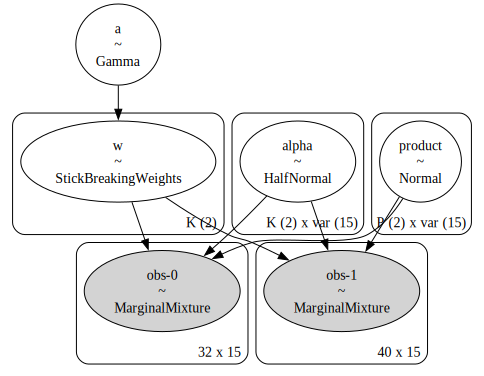

In [249]:
# 構造
modeldag = pm.model_to_graphviz(model_dirichlet)
display(modeldag)


In [250]:
model_dirichlet.debug(verbose=True)

point={'a_log__': array(2.99573227), 'w_simplex__': array([-1.49786614]), 'alpha_log__': array([[4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019],
       [4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019]]), 'product': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}

No problems found


In [251]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_dirichlet:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=1, nuts_sampler="numpyro", 
                        random_seed=1, return_inferencedata=True,)
# >> Wall time: 45.5 s
# データの保存 to_netcdfの利用
# trace.to_netcdf('model_random1.nc')
# データの読み込み from_netcdfの利用
#trace = az.from_netcdf('model_random1.nc')

Compiling...
Compilation time =  0:00:00.947240
Sampling...


sample: 100%|██████████| 4000/4000 [00:11<00:00, 333.74it/s, 127 steps of size 3.09e-02. acc. prob=0.92]

Sampling time =  0:00:12.131814
Transforming variables...
Transformation time =  0:00:00.020259
CPU times: user 13.7 s, sys: 374 ms, total: 14.1 s
Wall time: 14.3 s


潜在変数を積分消去したので、numpyroでサンプリングできた

サンプラーが異なるので、ガンマ分布のパラメータを修正しないと、BinaryGibbsMetropolisと同じような結果が得られなかった

In [252]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [253]:
trace.posterior.a

<xarray.DataArray 'a' (chain: 1, draw: 3000)>
array([[6.01678606, 5.50839206, 5.60498768, ..., 5.55515056, 4.79240466,
        8.27340828]])
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 2993 2994 2995 2996 2997 2998 2999

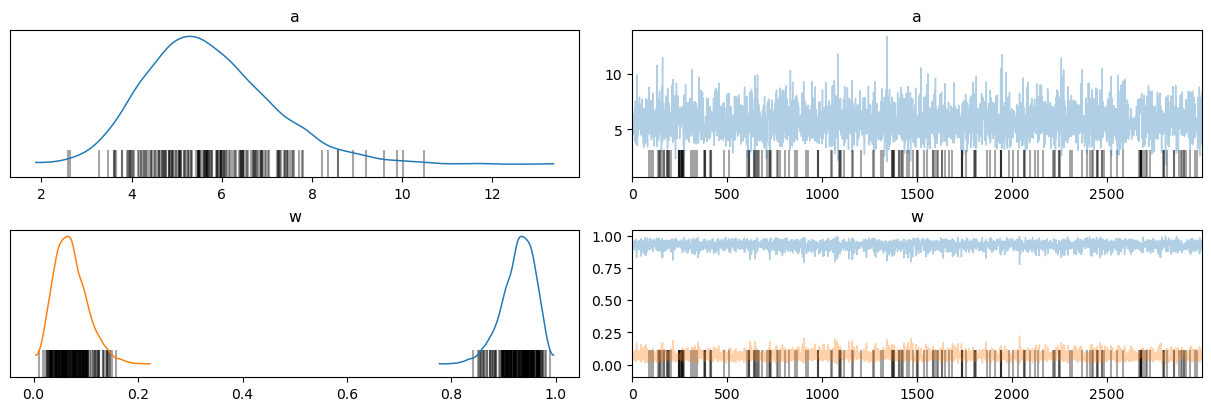

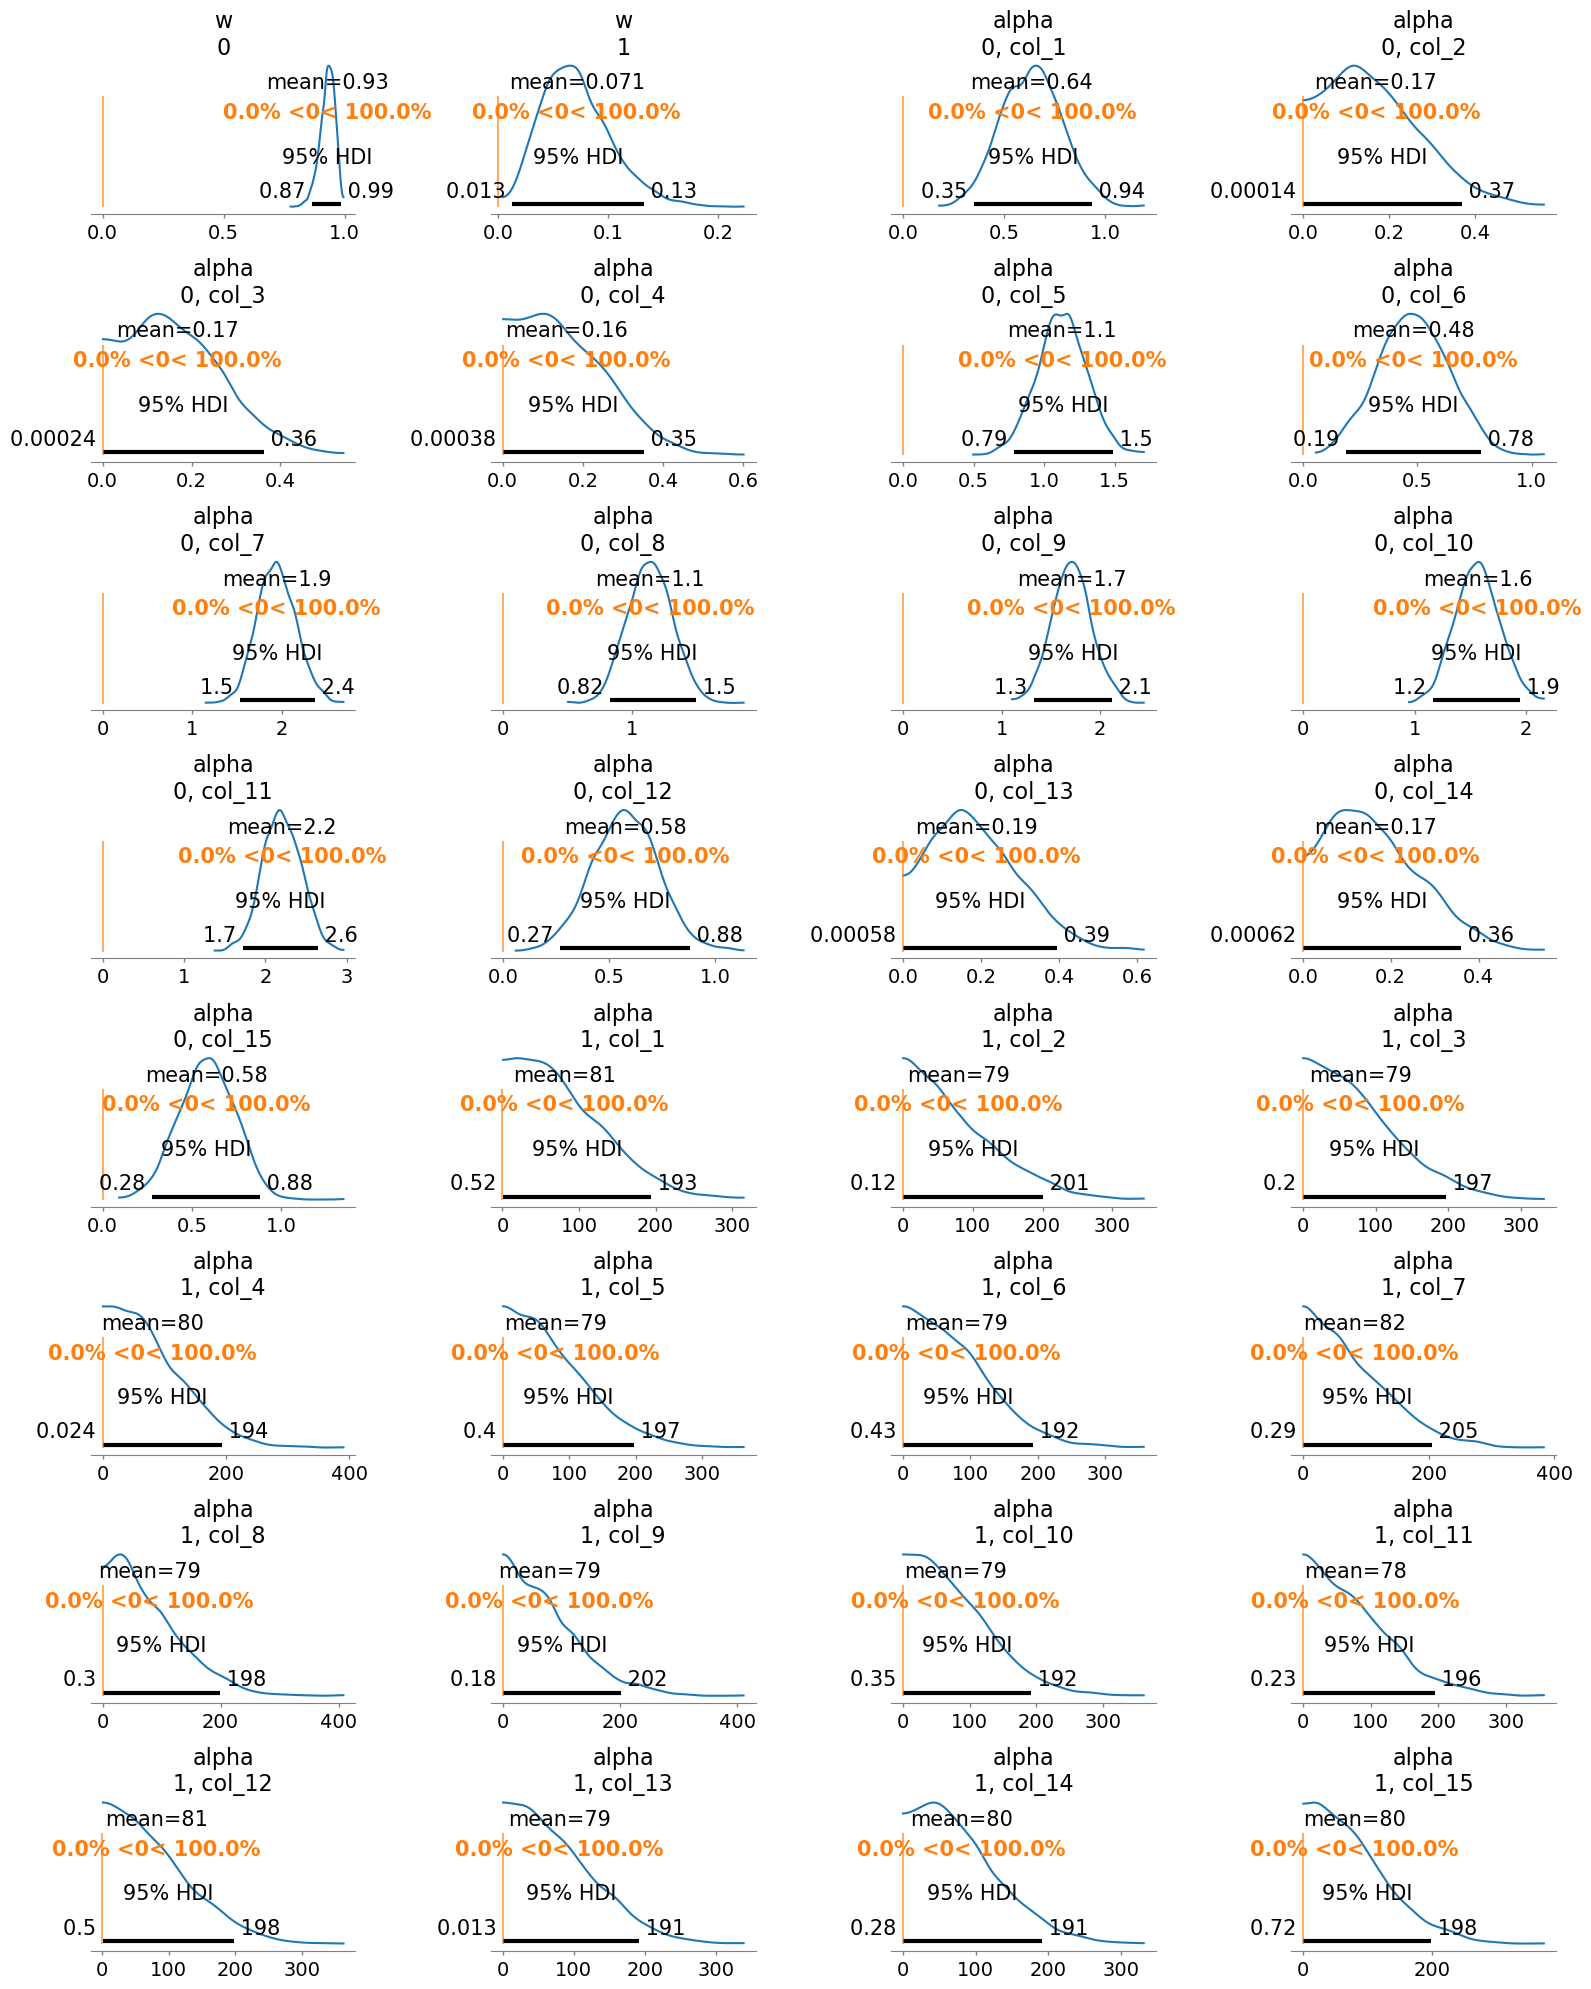

In [254]:
# # MCMCの収束を評価
# rhat_vals = az.rhat(trace).values()
# # 最大のRhatを確認
# result = np.max([np.max(i.values) for i in rhat_vals if i.name in ['w']])
# print('Max rhat:', result)
# # 1.1以上のRhatを確認
# for i in rhat_vals:
#     if np.max(i.values)>=1.1:
#         print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')


# トレースプロットとか
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=['a','w'])
plt.show()

# # forest plotでRハットと一緒に可視化
# az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["coef", "intercept", "random", 'mu'])
# plt.tight_layout()
# plt.show()

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=['w', 'alpha'], ref_val=0, figsize=(16,20))
plt.tight_layout()
plt.show()

# # Energy Plot
# az.plot_energy(trace)
# plt.show()


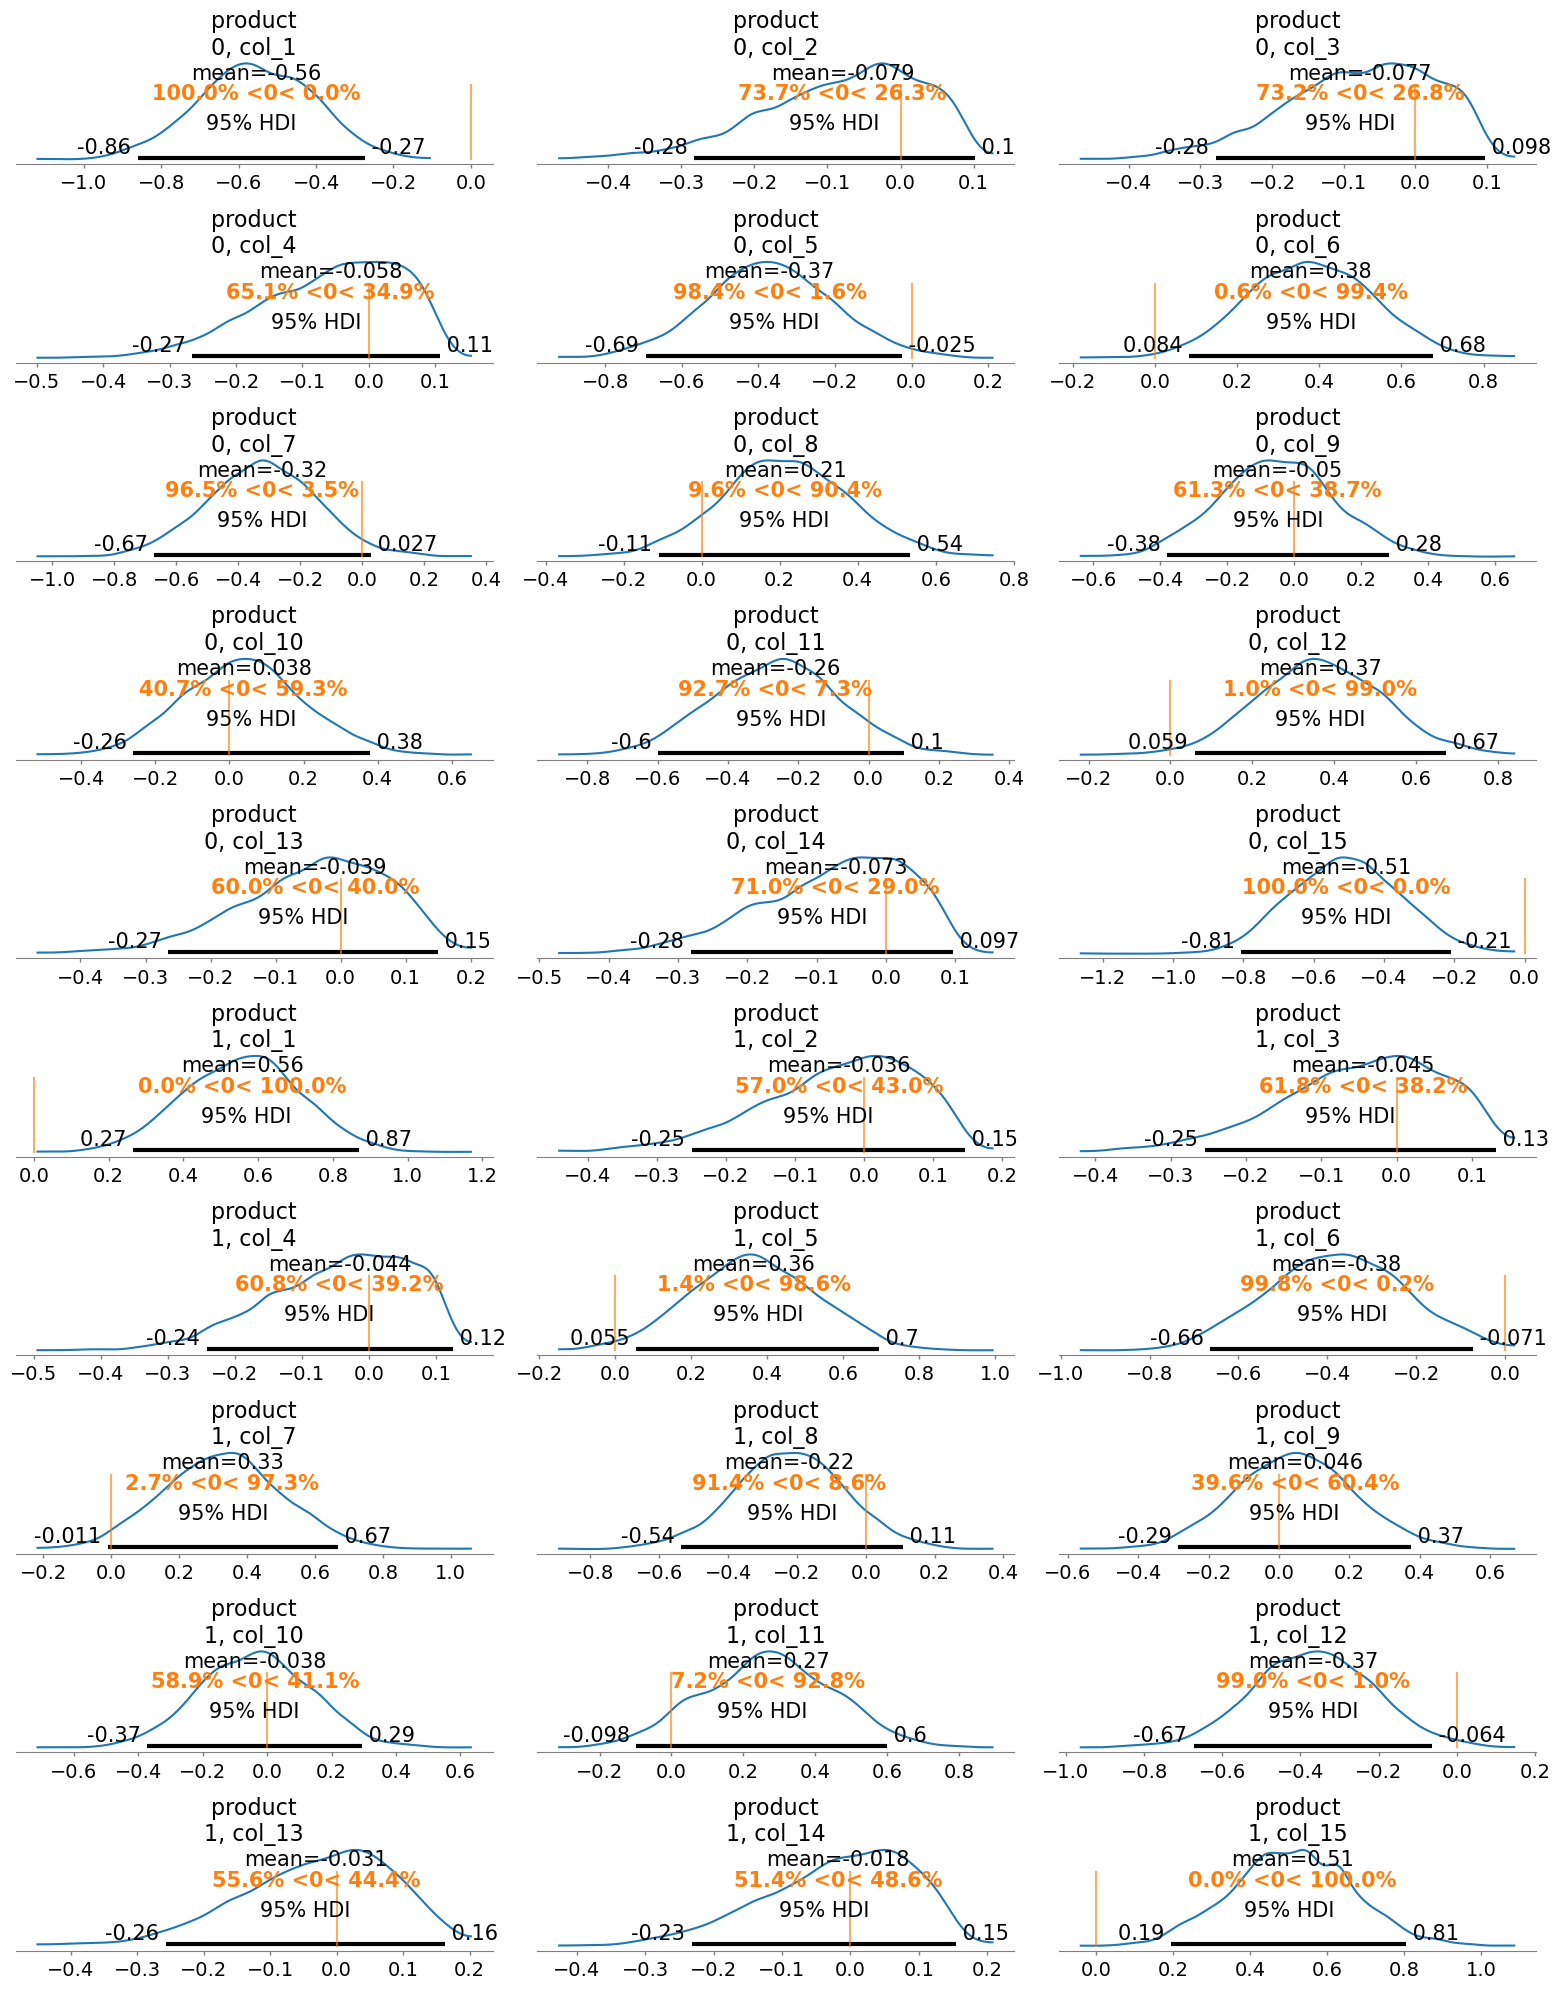

In [255]:

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=['product'], ref_val=0, figsize=(16,20))
plt.tight_layout()
plt.show()

# # Energy Plot
# az.plot_energy(trace)
# plt.show()


サンプリングされたラベルデータを観察

In [256]:
trace.posterior.w[0].shape

(3000, 2)

In [257]:
trace.posterior.w[0]

<xarray.DataArray 'w' (draw: 3000, K: 2)>
array([[0.94089301, 0.05910699],
       [0.93162524, 0.06837476],
       [0.9334821 , 0.0665179 ],
       ...,
       [0.89446123, 0.10553877],
       [0.94578259, 0.05421741],
       [0.89166897, 0.10833103]])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 2993 2994 2995 2996 2997 2998 2999
  * K        (K) int64 0 1

In [258]:
trace.posterior.w[0].mean(axis=0)

<xarray.DataArray 'w' (K: 2)>
array([0.9286007, 0.0713993])
Coordinates:
    chain    int64 0
  * K        (K) int64 0 1

頻度分布が大きく異なる場合はちゃんと検出できている

パラメータalphaのサンプリングを確認

In [259]:
# 各パラメータの事後分布の確認・評価（統計量）
df_summary = pm.summary(trace)
# df_summary['alpha_normal'] = df_summary['mean'] / df_summary['mean'].sum()
# df_summary['alpha_normal']
df_summary

arviz - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"product[0, col_1]",-0.555,0.151,-0.844,-0.280,0.004,0.003,1422.0,1718.0,NaN
"product[0, col_2]",-0.079,0.109,-0.283,0.089,0.003,0.002,1041.0,949.0,NaN
"product[0, col_3]",-0.077,0.106,-0.264,0.097,0.004,0.003,739.0,629.0,NaN
"product[0, col_4]",-0.058,0.107,-0.254,0.107,0.003,0.002,974.0,1443.0,NaN
"product[0, col_5]",-0.371,0.168,-0.701,-0.060,0.004,0.003,1526.0,1728.0,NaN
...,...,...,...,...,...,...,...,...,...
"alpha[1, col_11]",77.787,59.458,0.229,186.863,1.069,0.756,1809.0,955.0,NaN
"alpha[1, col_12]",80.973,60.657,0.498,190.142,1.000,0.707,2239.0,1351.0,NaN
"alpha[1, col_13]",79.436,58.701,0.013,184.315,1.050,0.742,1866.0,1125.0,NaN
"alpha[1, col_14]",80.287,57.442,0.037,183.502,0.940,0.665,2421.0,1331.0,NaN


In [260]:
df_p0 = df_summary.loc[[ind for ind in df_summary.index if 'product[0,' in ind]]
df_p1 = df_summary.loc[[ind for ind in df_summary.index if 'product[1,' in ind]]
delta = df_p1['mean'].values - df_p0['mean'].values
delta/5

array([ 0.2226,  0.0086,  0.0064,  0.0028,  0.1472, -0.1516,  0.1304,
       -0.0872,  0.0192, -0.0152,  0.1068, -0.1466,  0.0016,  0.011 ,
        0.2034])

In [261]:
p1_cor

array([ 0.08121727, -0.03058782, -0.02640859, -0.05364843,  0.04327038,
       -0.11507693,  0.08724059, -0.03806035,  0.01595195, -0.01246852,
        0.0731054 , -0.10300704, -0.01612086, -0.01920272,  0.05668847])

In [262]:
df_check = pd.DataFrame()
df_check['true'] = p1_cor / np.abs(p1_cor).sum()
df_check['mcmc'] = delta / np.abs(delta).sum()
df_check

,true,mcmc
0,0.105196,0.176583
1,-0.039619,0.006822
2,-0.034206,0.005077
3,-0.069488,0.002221
4,0.056046,0.116770
5,-0.149053,-0.120260
6,0.112998,0.103443
7,-0.049297,-0.069173
8,0.020662,0.015231
9,-0.016150,-0.012058


ちゃんと推定できている

In [263]:
df_summary.loc['a']

mean            5.678
sd              1.392
hdi_3%          3.284
hdi_97%         8.365
mcse_mean       0.023
mcse_sd         0.017
ess_bulk     3595.000
ess_tail     2397.000
r_hat             NaN
Name: a, dtype: float64

## αのヒストグラムを正解と推定で確認する

In [264]:
df_a0 = df_summary.loc[[ind for ind in df_summary.index if 'alpha[0,' in ind]]
df_a0['alpha_p0'] = df_a0['mean'].values + df_p0['mean'].values
df_a0['alpha_p0_normal'] = df_a0['alpha_p0'] / df_a0['alpha_p0'].sum()

df_a0['alpha_p1'] = df_a0['mean'].values + df_p1['mean'].values
df_a0['alpha_p1_normal'] = df_a0['alpha_p1'] / df_a0['alpha_p1'].sum()

df_a0['alpha_normal'] = df_a0['mean'] / df_a0['mean'].sum()
df_a0

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,alpha_p0,alpha_p0_normal,alpha_p1,alpha_p1_normal,alpha_normal
"alpha[0, col_1]",0.637,0.151,0.368,0.932,0.004,0.003,1446.0,1746.0,NaN,0.082,0.007186,1.195,0.087175,0.049719
"alpha[0, col_2]",0.169,0.109,0.001,0.360,0.003,0.002,1033.0,859.0,NaN,0.090,0.007887,0.133,0.009702,0.013191
"alpha[0, col_3]",0.168,0.106,0.000,0.348,0.004,0.003,636.0,465.0,NaN,0.091,0.007975,0.123,0.008973,0.013113
"alpha[0, col_4]",0.158,0.106,0.001,0.342,0.003,0.002,972.0,1154.0,NaN,0.100,0.008763,0.114,0.008316,0.012332
"alpha[0, col_5]",1.128,0.178,0.785,1.456,0.005,0.003,1396.0,1566.0,NaN,0.757,0.066339,1.493,0.108915,0.088042
"alpha[0, col_6]",0.483,0.154,0.206,0.779,0.004,0.003,1209.0,1118.0,NaN,0.862,0.075541,0.104,0.007587,0.037699
"alpha[0, col_7]",1.944,0.217,1.555,2.358,0.005,0.003,2269.0,1898.0,NaN,1.620,0.141968,2.272,0.165743,0.151733
"alpha[0, col_8]",1.136,0.173,0.819,1.453,0.004,0.003,2003.0,1807.0,NaN,1.350,0.118307,0.914,0.066676,0.088667
"alpha[0, col_9]",1.709,0.202,1.330,2.098,0.004,0.003,2460.0,1973.0,NaN,1.659,0.145386,1.755,0.128027,0.133391
"alpha[0, col_10]",1.562,0.200,1.204,1.950,0.004,0.003,2026.0,2114.0,NaN,1.600,0.140216,1.524,0.111176,0.121917


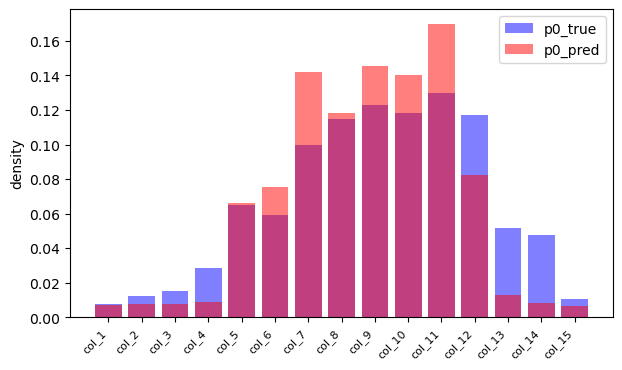

In [266]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, X_hist[product==0].mean(axis=0), color='blue', alpha=0.5, label='p0_true')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_a0['alpha_p0_normal'].values, color='red', alpha=0.5, label='p0_pred')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

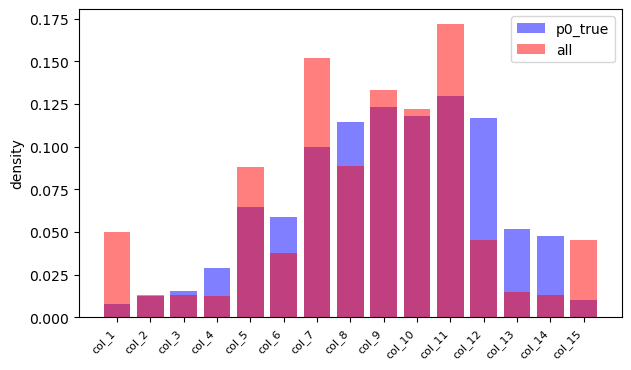

In [267]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, X_hist[product==0].mean(axis=0), color='blue', alpha=0.5, label='p0_true')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_a0['alpha_normal'].values, color='red', alpha=0.5, label='all')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

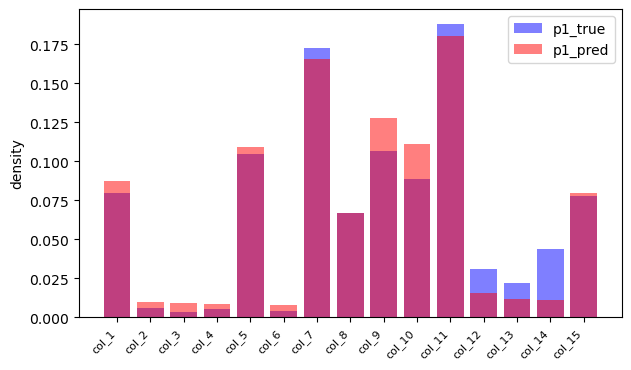

In [268]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, X_hist[product==1].mean(axis=0), color='blue', alpha=0.5, label='p1_true')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_a0['alpha_p1_normal'].values, color='red', alpha=0.5, label='p1_pred')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

# Automatic Differentiation Variational Inference (ADVI)で推論

潜在変数を積分消去しているので、ADVIが使用できる（カテゴリー変数＝離散変数があると使用できない）

参考：https://learning-with-machine.hatenablog.com/entry/2020/03/26/212328#ADVIによる推論

In [270]:
X_cols = [f'col_{i+1}' for i in range(data_.shape[1])]

K = 2
P = 2

# モデルの定義
with pm.Model() as model_dirichlet:
    # coords(次元やインデックスを定義)
    model_dirichlet.add_coord('data', values=range(data_.shape[0]), mutable=True)
    model_dirichlet.add_coord('var', values=X_cols, mutable=True)
    model_dirichlet.add_coord('K', values=range(K), mutable=True)
    model_dirichlet.add_coord('P', values=range(P), mutable=True)

    # 説明変数
    # x = pm.MutableData('x', data_, dims=('data','var'))

    # 混合比の生成
    a = pm.Gamma('a', 20, 1)
    # a = pm.Uniform('a', lower=0.00001, upper=1)
    w = pm.StickBreakingWeights('w', alpha=a, K=K-1, dims=('K',))

    # 推論パラメータの事前分布
    alpha_ = pm.HalfNormal('alpha', dims=('K','var'), sigma=100)
    pro_ = pm.Normal('product', mu=0, sigma=0.2, dims=('P','var'))
    # pro_ = pm.HalfNormal('product', sigma=1, dims=('P','var'))

    # Dirichlet分布
    for pro_id in range(P):
        components = pm.Dirichlet.dist(a=pm.math.maximum(alpha_ + pro_[pro_id],0), shape=(K,len(X_cols)))# maximumを通して負の値を0に置換する
        result = pm.Mixture(f'obs-{pro_id}', w=w, comp_dists=components, observed=data_[product==pro_id])#, dims=('data','var'))


# 定義した各パラメータの情報
display(model_dirichlet.model)

In [275]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_dirichlet:
    # ADVIによる推論
    approx = pm.fit(n=15000, obj_optimizer=pm.adagrad(learning_rate=1e-2),
                    method='advi', random_seed=1)

# learning_rate=1e-1とすると、FloatingPointError: NaN occurred in optimization. のエラーとなった

Finished [100%]: Average Loss = 1.0837e+05


CPU times: user 3.14 s, sys: 157 ms, total: 3.3 s
Wall time: 3.27 s


In [276]:
approx.hist

array([408866.84236713, 363972.09366407, 599390.20395802, ...,
        98934.94399606, 128240.79820643, 108658.03005909])

Text(0, 0.5, 'ELBO')

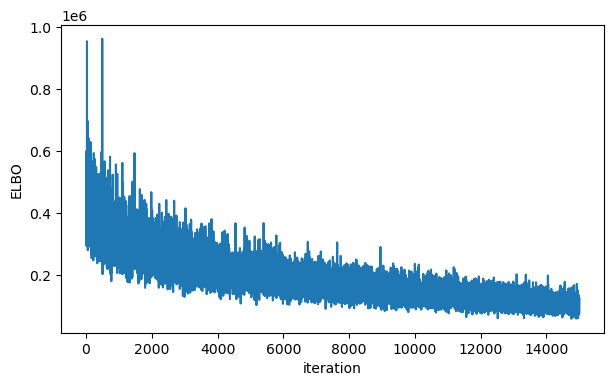

In [277]:
# ELBOをプロット
fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1,1)

ax.plot(approx.hist)
ax.set_xlabel('iteration')
ax.set_ylabel('ELBO')

変分法で推定した近似分布からパラメータの値をサンプリングする

In [278]:
# 事後分布からのサンプリング
sample_post_advi = approx.sample(1000, random_seed=1)
sample_post_advi


Inference data with groups:
	> posterior
	> observed_data

In [279]:
df_summary_advi = pm.summary(sample_post_advi)
df_summary_advi

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"product[0, col_1]",-2.388,0.639,-3.641,-1.309,0.022,0.015,874.0,975.0,NaN
"product[0, col_2]",-2.361,0.657,-3.497,-1.015,0.021,0.015,1009.0,912.0,NaN
"product[0, col_3]",-2.358,0.646,-3.493,-1.174,0.020,0.014,1061.0,979.0,NaN
"product[0, col_4]",-2.331,0.608,-3.536,-1.268,0.019,0.013,1066.0,908.0,NaN
"product[0, col_5]",-1.128,0.402,-1.859,-0.374,0.012,0.009,1077.0,1036.0,NaN
...,...,...,...,...,...,...,...,...,...
"alpha[1, col_11]",114.589,41.057,50.952,194.002,1.332,0.942,936.0,980.0,NaN
"alpha[1, col_12]",26.737,13.547,7.950,51.695,0.448,0.317,903.0,908.0,NaN
"alpha[1, col_13]",27.723,13.310,7.469,49.190,0.423,0.299,902.0,914.0,NaN
"alpha[1, col_14]",25.819,13.835,6.281,51.529,0.444,0.315,978.0,847.0,NaN


In [280]:
df_p0 = df_summary_advi.loc[[ind for ind in df_summary_advi.index if 'product[0,' in ind]]
df_p1 = df_summary_advi.loc[[ind for ind in df_summary_advi.index if 'product[1,' in ind]]
delta = df_p1['mean'].values - df_p0['mean'].values

In [281]:
df_check = pd.DataFrame()
df_check['true'] = p1_cor / np.abs(p1_cor).sum()
df_check['mcmc'] = delta / np.abs(delta).sum()
df_check

,true,mcmc
0,0.105196,0.192862
1,-0.039619,0.002705
2,-0.034206,0.001882
3,-0.069488,0.000353
4,0.056046,0.101252
5,-0.149053,-0.156759
6,0.112998,0.052802
7,-0.049297,-0.082789
8,0.020662,-0.002705
9,-0.016150,-0.022285


In [282]:
df_a0 = df_summary_advi.loc[[ind for ind in df_summary_advi.index if 'alpha[0,' in ind]]
df_a0['alpha_p0'] = df_a0['mean'].values + df_p0['mean'].values
df_a0['alpha_p0_normal'] = df_a0['alpha_p0'] / df_a0['alpha_p0'].sum()

df_a0['alpha_p1'] = df_a0['mean'].values + df_p1['mean'].values
df_a0['alpha_p1_normal'] = df_a0['alpha_p1'] / df_a0['alpha_p1'].sum()

df_a0['alpha_normal'] = df_a0['mean'] / df_a0['mean'].sum()
df_a0

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,alpha_p0,alpha_p0_normal,alpha_p1,alpha_p1_normal,alpha_normal
"alpha[0, col_1]",44.596,30.944,7.429,91.777,0.978,0.697,1033.0,944.0,NaN,42.208,0.044463,45.488,0.047791,0.046173
"alpha[0, col_2]",45.858,29.527,8.562,98.020,0.956,0.676,944.0,983.0,NaN,43.497,0.045821,43.543,0.045748,0.047479
"alpha[0, col_3]",43.267,27.240,10.454,90.601,0.853,0.615,1074.0,812.0,NaN,40.909,0.043094,40.941,0.043014,0.044797
"alpha[0, col_4]",42.959,27.113,7.744,87.291,0.890,0.630,989.0,909.0,NaN,40.628,0.042798,40.634,0.042692,0.044478
"alpha[0, col_5]",68.934,40.128,14.132,132.621,1.295,0.916,947.0,944.0,NaN,67.806,0.071428,69.528,0.073049,0.071371
"alpha[0, col_6]",45.129,27.287,10.383,97.460,0.841,0.595,1044.0,975.0,NaN,45.431,0.047858,42.765,0.044931,0.046725
"alpha[0, col_7]",110.363,50.531,32.212,204.633,1.539,1.091,1006.0,912.0,NaN,109.962,0.115836,110.860,0.116474,0.114265
"alpha[0, col_8]",66.574,35.324,15.279,131.204,1.217,0.861,754.0,845.0,NaN,67.066,0.070649,65.658,0.068983,0.068928
"alpha[0, col_9]",96.828,43.704,27.793,174.437,1.346,0.952,1051.0,971.0,NaN,96.913,0.102090,96.867,0.101772,0.100251
"alpha[0, col_10]",88.985,41.650,25.843,163.215,1.348,0.954,934.0,739.0,NaN,89.215,0.093981,88.836,0.093335,0.092131


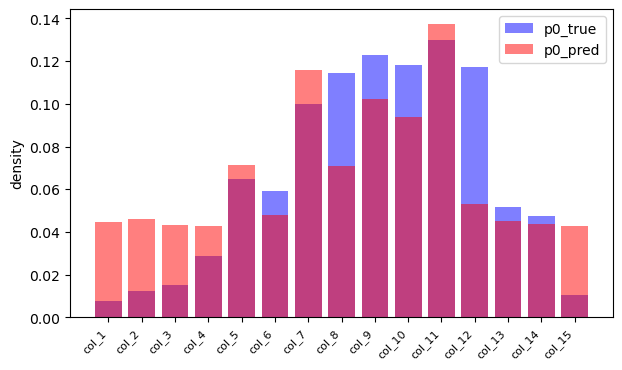

In [283]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, X_hist[product==0].mean(axis=0), color='blue', alpha=0.5, label='p0_true')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_a0['alpha_p0_normal'].values, color='red', alpha=0.5, label='p0_pred')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

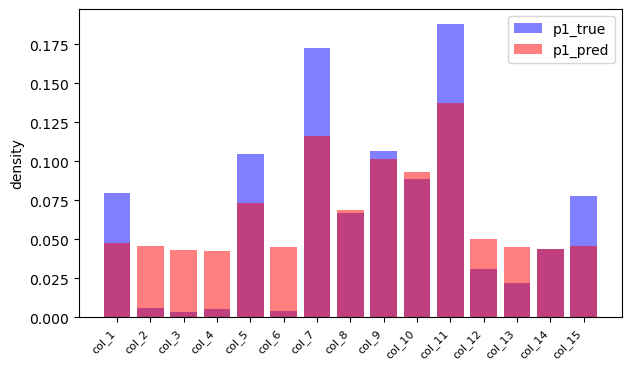

In [284]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, X_hist[product==1].mean(axis=0), color='blue', alpha=0.5, label='p1_true')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_a0['alpha_p1_normal'].values, color='red', alpha=0.5, label='p1_pred')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示